In [49]:
import pandas as pd
import statsmodels.api as sm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

### Create Maps from Survey Options to CoStar

In [50]:
market_map = {
    'Atlanta': 'Atlanta, GA',
    'Austin': 'Austin, TX',
    'Charlotte': 'Charlotte, NC',
    'Columbus': 'Columbus, OH',
    'DC': 'Washington, DC',
    'Dallas': 'Dallas, TX',
    'Denver': 'Denver, CO',
    'Houston': 'Houston, TX',
    'Nashville': 'Nashville, TN',
    'Orlando': 'Orlando, FL',
    'Phoenix': 'Phoenix, AZ',
    'Raleigh': 'Raleigh, NC',
    'South Florida': 'Miami, FL',
    'Tampa': 'Tampa, FL',
    'Tucson': 'Tucson, AZ'
}

manager_map = {
    'amli': 'AMLI',
    'arium': 'Arium',
    'avalon': 'AvalonBay',
    'bell': 'Bell',
    'bozzuto': 'Bozzuto',
    'broadstone': 'Broadstone',  
    'camden': 'Camden',
    'cortland': 'Cortland',
    'cushman_&_wakefield': 'Pinnacle', 
    'encantada': 'HSL', 
    'gables': 'Gables', 
    # 'greenwater': 'Greenwater',
    'greystar': 'Greystar',
    'hsl': 'HSL', 
    'lincoln': 'Willow Bridge', 
    'maa': 'MAA',
    'mark_taylor': 'Mark Taylor',
    'northstar': 'Northstar', 
    'northwood': 'Northwood Ravin', 
    'pb_bell': 'Bell',
    'pinnacle': 'Pinnacle',
    'post': 'Post Road',
    'rpm_living': 'RPM',
    'walton': 'Walton Communities', 
    'weidner': 'Weidner',
    'windsor': 'Windsor'
}

### Read in Raw HelloData Property Details and Reference File

In [51]:
hellodata_costar_ref = pd.read_csv('data/hellodata_costar_ref.csv')

hellodata_cols = [
    'UnitCount', 'NumberStories',
    'PropertyQuality', 'BuildingAge', 'BedroomQuality', 
    'KitchenQuality', 'BathroomQuality', 'DiningRoomQuality', 'CommonAreasQuality', 
    'FitnessCenterQuality', 'LaundryRoomQuality', 'LivingRoomQuality', 'MainEntranceQuality'
]

property_details = pd.read_csv('data/property_details.csv')
property_details = property_details[['HelloDataID'] + hellodata_cols]

property_details = pd.merge(property_details, hellodata_costar_ref, left_on='HelloDataID', right_on='property_id', how='outer').drop(columns=['property_id']).dropna(subset='HelloDataID')

C:\Users\tyson.king\AppData\Local\Temp\ipykernel_32012\2301443739.py:10: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  property_details = pd.read_csv('data/property_details.csv')


### Read in Raw CoStar Export

In [54]:
costar_export = pd.read_csv('data/branded_sites.csv')

costar_export = costar_export[['PropertyID', 'MarketName', 'SubMarketName', 'manager', 'Latitude', 'Longitude']]

costar_export = pd.merge(costar_export, property_details, left_on='PropertyID', right_on='costar_id', how='left')

### Read in Raw Survey Data and Format Columns

In [56]:
raw_survey_data = pd.read_csv('data/raw_survey_data.csv',encoding='latin1')\
    .rename(columns={'Market': 'market',
                     'Which of the following best describes your current living situation?':'living',
                     'What is your combined, annual household income?':'income',
                     'What is theÂ\xa0total monthly rent payment (for all bedrooms)Â\xa0where you live? The total rent forÂ\xa0all bedrooms, not just your portion of the rent.Â\xa0':'total_rent',
                     'What is your age?':'age',
                     'Cortland Unaided': 'cortland_unaided',
                     'Camden Unaided': 'camden_unaided',
                     'Greystar Unaided': 'greystar_unaided',
                     'MAA Unaided': 'maa_unaided'})

raw_survey_data['cortland_unaided'] = raw_survey_data['cortland_unaided'].notna().astype(int)
raw_survey_data['camden_unaided']   = raw_survey_data['camden_unaided'].notna().astype(int)
raw_survey_data['greystar_unaided'] = raw_survey_data['greystar_unaided'].notna().astype(int)
raw_survey_data['maa_unaided']      = raw_survey_data['maa_unaided'].notna().astype(int)

aided_cols = [col for col in raw_survey_data.columns if col.startswith('<strong>')]

for col in aided_cols:
    match = re.search(r'<strong>(.*?)</strong>', col)
    if match:
        brand = match.group(1).strip().lower().replace(' ', '_')
        new_col = f"{brand}_aided"
        raw_survey_data[new_col] = raw_survey_data[col].notna().astype(int)

survey_df = raw_survey_data[[
    col for col in raw_survey_data.columns
    if col in ['market', 'living', 'income', 'total_rent', 'age']
    or col.endswith('_aided') or col.endswith('_unaided')
]]

### Aggregate Survey Data to get Income, Rent and Age

In [57]:
def extract_upper_income(val):
    if 'or more' in val:
        return 200000
    match = re.search(r'under\s*\$?([\d,]+)', val)
    if match:
        return int(match.group(1).replace(',', ''))
    return None

def extract_upper_rent(val):
    if 'More than' in val:
        return 3000
    match = re.search(r'\$[\d,]+ - \$([\d,]+)', val)
    if match:
        return int(match.group(1).replace(',', ''))
    return None


survey_df['income'] = survey_df['income'].apply(extract_upper_income)
survey_df['total_rent'] = survey_df['total_rent'].apply(extract_upper_rent)

market_demos = survey_df.groupby('market').agg({
    'income': 'mean',
    'age': 'mean',
    'total_rent': 'mean'
}).reset_index()

market_demos['market'] = market_demos['market'].map(market_map)

C:\Users\tyson.king\AppData\Local\Temp\ipykernel_32012\2906079784.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_df['income'] = survey_df['income'].apply(extract_upper_income)
C:\Users\tyson.king\AppData\Local\Temp\ipykernel_32012\2906079784.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_df['total_rent'] = survey_df['total_rent'].apply(extract_upper_rent)


### Aggregate Survey Data to get Recognition

In [59]:
aided_cols = [col for col in raw_survey_data.columns if col.endswith('_aided')]

melted = survey_df[['market'] + aided_cols].melt(
    id_vars='market',
    value_vars=aided_cols,
    var_name='manager',
    value_name='recognized'
)

melted['manager'] = melted['manager'].str.replace('_aided', '', regex=False)

brand_recognition = (
    melted.groupby(['market', 'manager'], as_index=False)['recognized']
    .mean()
    .rename(columns={'recognized': 'recognition'})
)

brand_recognition['market'] = brand_recognition['market'].map(market_map)
brand_recognition['manager'] = brand_recognition['manager'].map(manager_map)

### Create Num Stories Binned Dummy Variables

In [66]:
bins = [0, 3, 6, 10, 15, float('inf')]
labels = ['1-3', '4-6', '7-10', '11-15', '15+']

costar_export['stories_bin'] = pd.cut(costar_export['NumberStories'], bins=bins, labels=labels)

market_bin_totals = (
    costar_export
    .groupby(['MarketName', 'stories_bin'])['PropertyID']
    .nunique()
    .reset_index(name='total_props_in_bin')
)

manager_bin_counts = (
    costar_export
    .groupby(['MarketName', 'manager', 'stories_bin'])['PropertyID']
    .nunique()
    .reset_index(name='manager_props_in_bin')
)

merged = pd.merge(manager_bin_counts, market_bin_totals, on=['MarketName', 'stories_bin'], how='left')
merged['pct_of_market_bin'] = merged['manager_props_in_bin'] / merged['total_props_in_bin']

binned_pct = (
    merged
    .pivot(index=['MarketName', 'manager'], columns='stories_bin', values='pct_of_market_bin')
    .fillna(0)
    .reset_index()
)

binned_pct.columns.name = None
binned_pct = binned_pct.rename(columns={
    '1-3': 'prop_1_3_stories',
    '4-6': 'prop_4_6_stories',
    '7-10': 'prop_7_10_stories',
    '11-15': 'prop_11_15_stories',
    '15+': 'prop_15_plus_stories'
})

manager_totals = costar_export.groupby(
    ['MarketName', 'manager']
).agg(
    total_units = ('UnitCount', 'sum')
).reset_index()

manager_metrics = pd.merge(
    manager_totals,
    binned_pct,
    on=['MarketName', 'manager'],
    how='left'
)

C:\Users\tyson.king\AppData\Local\Temp\ipykernel_32012\3664201407.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['MarketName', 'stories_bin'])['PropertyID']
C:\Users\tyson.king\AppData\Local\Temp\ipykernel_32012\3664201407.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['MarketName', 'manager', 'stories_bin'])['PropertyID']


### Aggregate HelloData Quality Metrics

In [71]:
cols_to_exclude = ['PropertyID', 'UnitCount', 'Latitude', 'Longitude', 'HelloDataID', 'costar_id', 'SubMarketName', 'stories_bin']
cols_to_agg = [col for col in costar_export.columns if col not in cols_to_exclude + ['MarketName', 'manager']]

costar_export[cols_to_agg] = costar_export[cols_to_agg].apply(
    lambda col: col.fillna(col.mean()) if col.dtype.kind in 'biufc' else col
)

hellodata_metrics = (
    costar_export.groupby(['MarketName', 'manager'])[cols_to_agg]
    .mean()
    .reset_index()
)

### Final Aggregation

In [73]:
final_metrics = pd.merge(manager_metrics, brand_recognition, left_on=['MarketName', 'manager'], right_on=['market', 'manager'], how='right')
final_metrics = pd.merge(final_metrics, hellodata_metrics, on=['MarketName', 'manager'], how='left')
final_metrics = pd.merge(final_metrics, market_demos, on='market', how='left')

final_metrics = final_metrics.drop(columns=['MarketName']).dropna(subset=['total_units'])

### Fill NAs

### Train Model

In [74]:
x = final_metrics.drop(columns=['market', 'manager', 'recognition'])
y = final_metrics['recognition']

model = sm.OLS(y, x)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            recognition   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.750
Method:                 Least Squares   F-statistic:                              25.52
Date:                Tue, 08 Jul 2025   Prob (F-statistic):                    2.41e-39
Time:                        13:57:10   Log-Likelihood:                          157.29
No. Observations:                 172   AIC:                                     -272.6
Df Residuals:                     151   BIC:                                     -206.5
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [75]:
# Prepare data
X = final_metrics.drop(columns=['market', 'manager', 'recognition'])
y = final_metrics['recognition']

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# ElasticNetCV for feature selection
enet = ElasticNetCV(cv=5, l1_ratio=0.5, random_state=42)
enet.fit(X_scaled, y)

# Get selected features (non-zero coefficients)
selected_features = X.columns[enet.coef_ != 0]

# Refit OLS on selected features
X_selected = sm.add_constant(X[selected_features])  # add intercept
ols_model = sm.OLS(y, X_selected)
ols_results = ols_model.fit()

# Print results
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:            recognition   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     10.31
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           1.09e-09
Time:                        13:57:36   Log-Likelihood:                 150.00
No. Observations:                 172   AIC:                            -286.0
Df Residuals:                     165   BIC:                            -264.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2417      0.10

### Diagnostic Plots

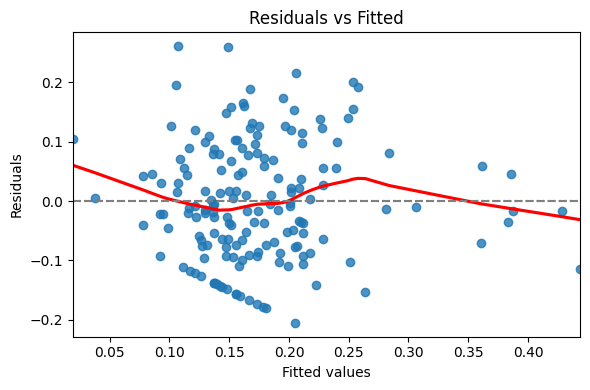

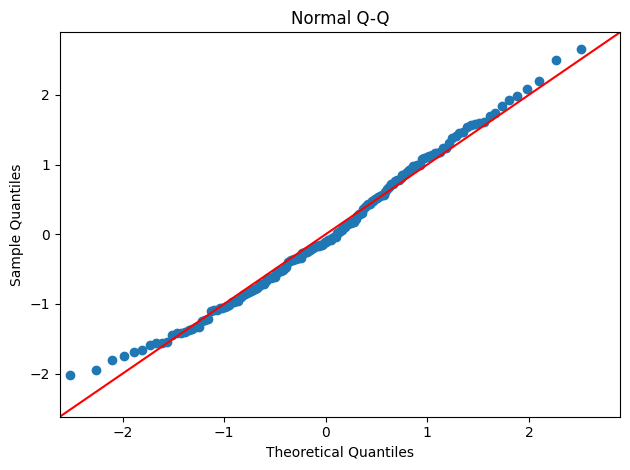

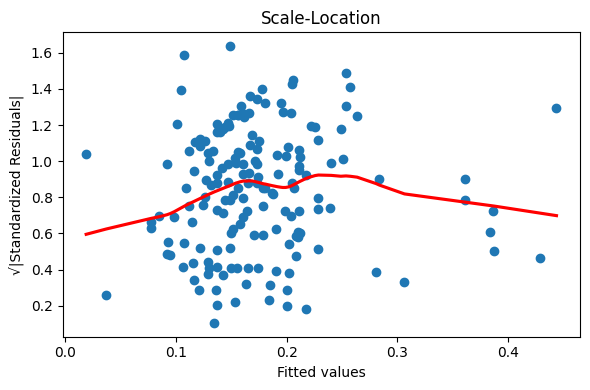

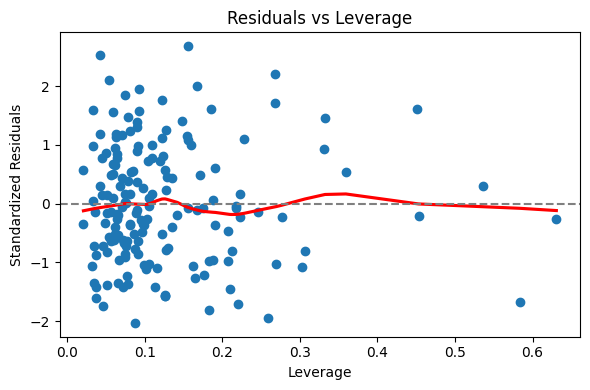

In [45]:
# Get fitted values and residuals
fitted_vals = results.fittedvalues
residuals = results.resid
standardized_residuals = results.get_influence().resid_studentized_internal
leverage = results.get_influence().hat_matrix_diag

# 1. Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.residplot(x=fitted_vals, y=y, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

# 2. Normal Q-Q
sm.qqplot(standardized_residuals, line='45', fit=True)
plt.title('Normal Q-Q')
plt.tight_layout()
plt.show()

# 3. Scale-Location (Spread vs Fitted)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_vals, abs(standardized_residuals) ** 0.5)
sns.regplot(x=fitted_vals, y=abs(standardized_residuals) ** 0.5,
            scatter=False, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('√|Standardized Residuals|')
plt.title('Scale-Location')
plt.tight_layout()
plt.show()

# 4. Leverage vs. Standardized Residuals
plt.figure(figsize=(6, 4))
plt.scatter(leverage, standardized_residuals)
sns.regplot(x=leverage, y=standardized_residuals, scatter=False,
            lowess=True, line_kws={'color': 'red'})
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Leverage')
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()